<a href="https://colab.research.google.com/github/berthine/SIAM-Summer-School/blob/main/Copy_of_GG_Summer_School_Course_2_Tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate
tf.keras.backend.set_floatx('float64')

##Question 2.a

First, lets calculate $q^*$ by iteratively solving for $q^l$, using equation (3) from the paper by Poole et al.

[0.96191186 6.10194911 4.44125522 4.15932025 4.09765146 4.08344536
 4.08013408 4.07936015 4.07917914 4.0791368 ]


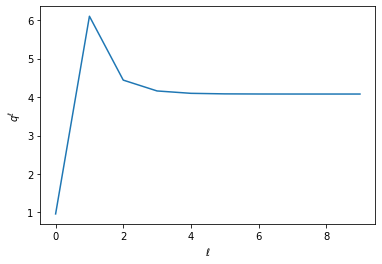

In [3]:
def normal(z):
  return (1/np.sqrt(2*np.pi))*np.exp(-(z**2)/2)

def integrand(z,q):
  return normal(z)*(np.tanh(np.sqrt(q)*z)**2)



N = 1000 #layer width
x = np.random.normal(size=N)

#use initial condition given in the paper
q0 = (1/len(x))*np.dot(x,x)
sw = 2.5
sb= 0.3
q1 = (sw**2)*q0 + sb**2 

qs = []
qs.append(q0)
qs.append(q1)


#iterate to convergence within specified tolerance
count = 0
while np.abs(qs[count+1]-qs[count])>1e-04:
  q1,_ = sp.integrate.quad(lambda z: integrand(z,q1), -np.inf, np.inf)
  q1 = (sw**2)*q1 + sb**2
  qs.append(q1)
  count+=1

# Display and plot the results
plt.plot(qs)
plt.xlabel('$\ell$')
plt.ylabel('$q^\ell$')
print(np.array(qs))


## Question 2.b

Next, lets design a feedforward networks, and calculate the length of each layer, averaged of the weights and biases



In [4]:
#function to  build feed fordward tanh net
def get_model(num_layers, width = N, sigma_w = 2.5, sigma_b = 0.3):  
  model = Sequential()
  kernel_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_w/np.sqrt(N))
  bias_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_b)
  for i in range(num_layers):
    a = Dense(width, kernel_initializer=kernel_initialiser, use_bias=True, bias_initializer=bias_initialiser)
    model.add(a)
    model.add(Activation('tanh'))

  return model

In [6]:
x = np.random.normal(size=(1,N))

num_layers = 7
num_samples = 100

average_layer_norms = np.zeros(num_layers)
for i in range(num_samples):
  # build new instance of model (i.e. new weights and biases)
  model = get_model(num_layers, width=N)
  model.build((None, N))
  #for
  
  # build function to collect pre-activation layers when an input is passed into the net
  inp = model.input
  out = [layer.output for layer in model.layers if isinstance(layer, Dense)]
  get_lay_outputs = K.function(inp, out)

  # Pass input  through the net to get layer outputs 
  pre_activation_layers = get_lay_outputs(x)

  # calculate squared 2-norm of each pre-activation layer
  for l, lay in enumerate(pre_activation_layers):
    h = lay[0,:]
    average_layer_norms[l]+=(np.linalg.norm(h,2)**2)/N
  
  #avoid memory problems by deleting model and clearing session
  del model
  tf.keras.backend.clear_session()

average_layer_norms=np.divide(average_layer_norms, num_samples)
average_layer_norms

array([6.57529283, 4.51258158, 4.17441143, 4.05544799, 4.07909194,
       4.05079124, 4.07772408])

In [7]:
average_layer_norms==np.array(qs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

## Question 2.c

Here,  we simply use what you proved in questiton 3, to calculate $\sigma_w$ from $q^*$, and the equation (3) - used above - to calculate $\sigma_b$ from $\sigma_w$ and $q^*$


In [ ]:
def d_tanh(z):
  return np.subtract(1, np.square(np.tanh(z)))

def chi_1_integrand(z, qstar):
  return normal(z)*(d_tanh(np.sqrt(qstar)*z))**2
  
def calc_sw(qstar):
  integral, _ = sp.integrate.quad(lambda z: chi_1_integrand(z,qstar), -np.inf, np.inf)
  return np.sqrt(np.divide(1,integral))

def calc_sb(qstar, sw):
  integral,_ = sp.integrate.quad(lambda z: integrand(z,qstar), -np.inf, np.inf)
  return np.sqrt(qstar - (sw**2)*integral)

In [ ]:
sigma_ws = []
sigma_bs = []
for qstar in np.linspace(0.1, 500, 1000):
  sw = calc_sw(qstar)
  sb = calc_sb(qstar, sw)
  sigma_ws.append(sw)
  sigma_bs.append(sb)

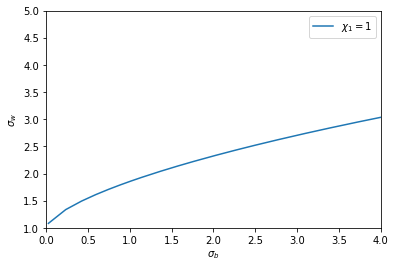

In [ ]:
#recreating the plot of the edge of chaos from Figure 2c in the Poole et al. paper
plt.plot(sigma_bs, sigma_ws, label = '$\chi_1 = 1$')
plt.xlim([0,4])
plt.ylim([1,5])
plt.xlabel('$\sigma_b$')
plt.ylabel('$\sigma_w$')
plt.legend()

## Question 2.d

In this question, we will pass 2 inputs through our feedforward net, and check their correlations $c_{12}$ at each  layer. Vary the values of $\sigma_w$ and $\sigma_b$ and see what happens. Note that one type of behaviour is easier to see when starting with correlated inputs, and the other is more easily visible when starting with uncorrelated inputs.

In [ ]:
N = 1000

x1 = np.random.normal(size=(1,N))
x2_sim = 3*x1.copy()
x2 = np.random.normal(size=(1,N))


num_samples = 20
num_layers = 25

#vary these
sigma_w1 = 1.3
sigma_w2 = 2.5
sigma_w3 = 4
sigma_b = 0.3

average_layer_corrs1 = np.zeros(num_layers)
average_layer_corrs2 = np.zeros(num_layers)
average_layer_corrs3 = np.zeros(num_layers)

for i in range(num_samples):
  model1 = get_model(num_layers, sigma_w = sigma_w1, sigma_b = sigma_b,width=N)
  model1.build((None, N))
  model2 = get_model(num_layers, sigma_w = sigma_w2, sigma_b = sigma_b,width=N)
  model2.build((None, N))
  model3 = get_model(num_layers, sigma_w = sigma_w3, sigma_b = sigma_b,width=N)
  model3.build((None, N))
  
  inp1 = model1.input
  out1 = [layer.output for layer in model1.layers if isinstance(layer, Dense)]
  get_lay_outputs1 = K.function(inp1, out1)
  pre_activation_layers11 = get_lay_outputs1(x1)
  pre_activation_layers12 = get_lay_outputs1(x2)
  
  for l in range(len(pre_activation_layers11)):
    h11 = pre_activation_layers11[l][0,:]
    h12 = pre_activation_layers12[l][0,:]
    average_layer_corrs1[l]+= np.corrcoef(h11, h12)[0,1]

  inp2 = model2.input
  out2 = [layer.output for layer in model2.layers if isinstance(layer, Dense)]
  get_lay_outputs2 = K.function(inp2, out2)
  pre_activation_layers21 = get_lay_outputs2(x1)
  pre_activation_layers22 = get_lay_outputs2(x2_sim)


  for l in range(len(pre_activation_layers21)):
    h21 = pre_activation_layers21[l][0,:]
    h22 = pre_activation_layers22[l][0,:]
    average_layer_corrs2[l]+= np.corrcoef(h21, h22)[0,1]

  inp3 = model3.input
  out3 = [layer.output for layer in model3.layers if isinstance(layer, Dense)]
  get_lay_outputs3 = K.function(inp3, out3)
  pre_activation_layers31 = get_lay_outputs3(x1)
  pre_activation_layers32 = get_lay_outputs3(x2_sim)


  for l in range(len(pre_activation_layers31)):
    h31 = pre_activation_layers31[l][0,:]
    h32 = pre_activation_layers32[l][0,:]
    average_layer_corrs3[l]+= np.corrcoef(h31, h32)[0,1]


  del model1, model2, model3
  tf.keras.backend.clear_session()

average_layer_corrs1=np.divide(average_layer_corrs1, num_samples)
average_layer_corrs2=np.divide(average_layer_corrs2, num_samples)
average_layer_corrs3=np.divide(average_layer_corrs3, num_samples)

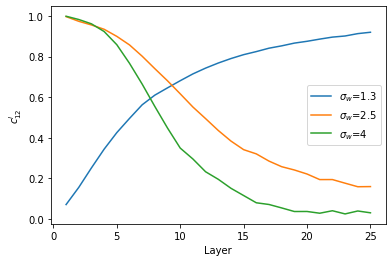

In [ ]:
plt.plot(np.arange(num_layers)+1, average_layer_corrs1)
plt.plot(np.arange(num_layers)+1, average_layer_corrs2)
plt.plot(np.arange(num_layers)+1, average_layer_corrs3)
plt.xlabel('Layer')
plt.ylabel('$c_{12}^l$')
plt.legend(('$\sigma_w$=1.3', '$\sigma_w$=2.5', '$\sigma_w$=4'))

## Question 7

For this question we will need a loss function, and so we will need dat with labels. We may as well use MNIST - though synthetic data would do just fine. 

In [ ]:
# Sample batch of MNIST data
(x_train, y_train), (x_test, y_test)= mnist.load_data()
batch_size = 128
x_batch = x_train[:batch_size, :, :]
y_batch = y_train[:batch_size]

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# functions to compute loss and gradients

def loss(model, x, y, training):
  y_hat = model(x)
  return loss_object(y_true=y, y_pred=y_hat)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)


# Function to build model

def get_model(num_layers, width = N, sigma_w = 2.5, sigma_b = 0.3):  
  model = Sequential()
  model.add(Flatten())
  kernel_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_w/np.sqrt(N))
  bias_initialiser = tf.random_normal_initializer(mean=0.0, stddev=sigma_b)
  for i in range(num_layers):
    model.add(Dense(width, kernel_initializer=kernel_initialiser, use_bias=True, bias_initializer=bias_initialiser))
    model.add(Activation('tanh'))
  model.add(Dense(10, kernel_initializer=kernel_initialiser, use_bias=True, bias_initializer=bias_initialiser))
  return model

Now we build a deep net, and vary $\sigma_w$ and $\sigma_b$ and examine the impact on the gradients

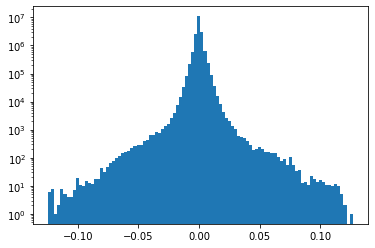

In [ ]:
num_layers = 30
#vary these
sigma_w = 1.3
sigma_b = 0.3
N = 28*28

model = get_model(num_layers, sigma_w = sigma_w, sigma_b = sigma_b,width=N)
loss_value,  grads = grad(model, x_batch, y_batch)

# plt.plot(np.concatenate([tf.reshape(g, -1) for g in grads]))

plt.hist(np.concatenate([tf.reshape(g, -1) for g in grads]), bins = 100, log=True);

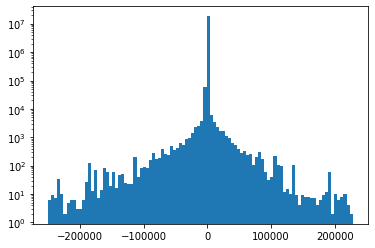

In [ ]:
num_layers = 30
#vary these
sigma_w = 4
sigma_b = 0.3
N = 28*28

model = get_model(num_layers, sigma_w = sigma_w, sigma_b = sigma_b,width=N)
loss_value,  grads = grad(model, x_batch, y_batch)


plt.hist(np.concatenate([tf.reshape(g, -1) for g in grads]), bins = 100, log=True);